In [1]:
import sys
sys.path.append('../')
from main import measurement_process_tomography, Quantities, tomographic_gate_set_tomography
import QuantumTomography as qt
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.compiler import transpile
import json
from qiskit.result import Result
from joblib import Parallel, delayed

In [2]:
def BarPlot( A , yerr=None, colors = ['r','b','g','y','r','b','g','y','r','b','g','y','r','b','g','y'], ax=None ):
    
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size"  : 22,
    "font.sans-serif": ["Helvetica"]})

    A = A.T
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot( 111, projection='3d' )
    
    lenx, leny = A.shape
    z = list(A)
    xs = np.arange(lenx)
    ys = np.arange(leny)
    
    for n in range(leny):
        zs = z[n]
        cs = colors[n]
        ax.bar( xs, A[n], n, zdir='y', color=cs, alpha=0.5)
        
        if yerr is not None:
            for i in xs:
                ax.plot( [i,i], [n, n], [A[n,i]+yerr[n,i], A[n,i]-yerr[n,i]], marker="_", color=cs)
        
    return ax
    
def Plot_Chois(  choi, error_choi=None, axes=None, z_lim = 0.1, shape = None, text=True  ) :
    
    N = len( choi )
    if shape is None:
        xx = 1
        yy = N
    else:
        xx = shape[0]
        yy = shape[1]
    
    if axes is None:
        fig = plt.figure(figsize=[yy*5,xx*5])
        axes = []
        for j in range(N):   
            axes.append( fig.add_subplot( xx, yy, j+1, projection='3d') )
            
    for j in range(N):
        ax = axes[j]
        if error_choi is None:
            ax = BarPlot( abs(choi[j]), None, ax=ax )
        else:
            ax = BarPlot( abs(choi[j]), error_choi[j], ax=ax )
        if text is True:
            ax.text( j*N+j, j*N+j, z_lim*1.1,  r'${}$'.format(np.round(abs(choi[j])[ j*N+j, j*N+j ],3))  )
        ax.set_zlim([0,z_lim])
    
    return axes
    

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')
#backend = provider.get_backend('ibmq_casablanca')
backend = provider.get_backend('ibmq_montreal')
simulator = Aer.get_backend('aer_simulator')

In [4]:
simulator = simulator.from_backend(backend)

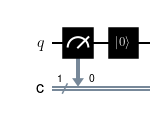

In [5]:
q1 = QuantumCircuit(1,1)
q1.measure(0,0)
q1.reset(0)
q1.draw( output='mpl' )

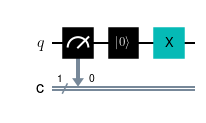

In [6]:
q2 = QuantumCircuit(1,1)
q2.measure(0,0)
q2.reset(0)
q2.x(0)
q2.draw( output='mpl' )

In [7]:
mpt1 = measurement_process_tomography( 1 )
mpt2 = measurement_process_tomography( 1 )
gst  = tomographic_gate_set_tomography( 1 )

In [8]:
circuits1 = mpt1.circuits(  )
circuits2 = mpt2.circuits( [ q1, q2 ] )
circuits3 = gst.circuits()

In [9]:
circuits = transpile( circuits3+circuits1+circuits2, backend, optimization_level=3)

In [10]:
#job = backend.run( circuits, shots=2**13 )
#job.job_id()
# 02/12/21 '61a933ae3d53f8685b9df9b2'
# 23/02/22 '6216319a57bc54e59562c374', '621632abacb5ef6c13d98922'
# 23/02/22 optimized '62163334bc41283d96b6acc8', '6216379c538b78834c8ee876'
# 23/02/22 ibmq_montreal '6216379c538b78834c8ee876'
# 23/02/22 gst '62163d9eacb5efc6d8d9893d'
#24/02/22 gst  '621762a361cbfc581b62f81f'

In [11]:
#job = backend.retrieve_job('621762a361cbfc581b62f81f')
#results = job.result()

In [10]:
with open('621762a361cbfc581b62f81f-output.json', 'r') as f:
  data = json.load(f)

In [11]:
def dict2results( dictionary ):

    results = Result( backend_name = dictionary['backend_name'],
                        backend_version = dictionary['backend_version'],
                        qobj_id = dictionary['qobj_id'],
                        job_id = dictionary['job_id'],
                        success = dictionary['success'],
                        results = dictionary['results'])

    results = results.from_dict( dictionary )

    return results
    

In [12]:
results = dict2results( data )

In [21]:
results.backend_version

'1.2.52'

In [15]:
gate_set = gst.fit(results)

In [16]:
states, measurements = gst.gateset2spam( gate_set )

In [17]:
chois1 = mpt1.fit( results )
povm1 = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0).flatten() for choi in chois1 ]).T
Quantities( povm1, chois1 )

(0.9528604612757282, 0.8840229953851573, 0.9265606791762313)

In [18]:
povm1

array([[ 9.86573055e-01+0.j        ,  1.34277592e-02+0.j        ],
       [-8.74960234e-04-0.01320384j,  8.74837445e-04+0.01320394j],
       [-8.74960234e-04+0.01320384j,  8.74837445e-04-0.01320394j],
       [ 8.08513183e-02+0.j        ,  9.19147868e-01+0.j        ]])

In [19]:
chois2 = mpt2.fit( results )
povm2  = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0 ).flatten() for choi in chois2 ]).T
Quantities( povm2, chois2 )

(0.9519842938932632, 0.8507320387493693, 0.8885509200709317)

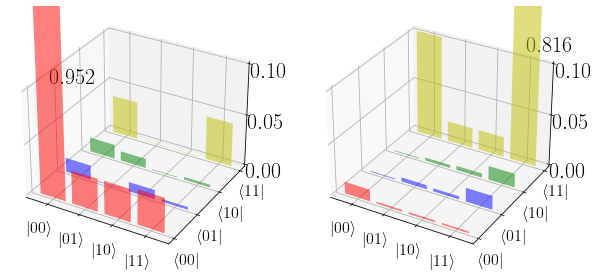

In [22]:
axes = Plot_Chois(chois1)
for ax in axes:
    ax.set_xticks( [0,1,2,3] )
    ax.set_xticklabels( [r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$',r'$|11\rangle$'], size=16 )
    ax.set_yticks( [0,1,2,3] )
    ax.set_yticklabels( [r'$\langle 00|$', r'$\langle 01|$', r'$\langle 10|$', r'$\langle 11|$'], size=16 )

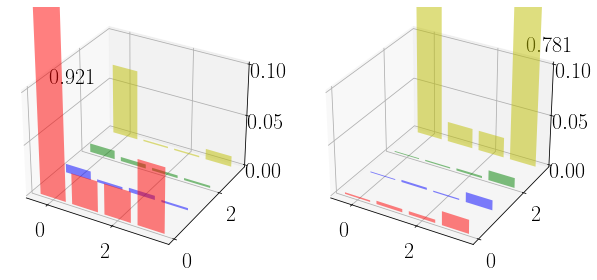

In [23]:
axes = Plot_Chois( chois2 )

In [51]:
def func():
    chois1 = mpt1.fit( results, gate_set=[states,measurements], resampling = 2**13 )
    povm1  = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0).flatten() for choi in chois1 ]).T
    q1     = Quantities( povm1, chois1 )

    return chois1, povm1, q1

data = Parallel( n_jobs=16 )( delayed(func)() for _ in range(1000)   )

chois1_loop = [ temp[0] for temp in data ]
povm1_loop  = [ temp[1] for temp in data ]
q1_loop     = [ temp[2] for temp in data ]

chois1     = np.mean( chois1_loop, axis=0 )
chois1_std = np.std( chois1_loop , axis=0 )
povm1      = np.mean( povm1_loop, axis=0 )
povm1_std  = np.std( povm1_loop , axis=0 )
q1         = np.mean( q1_loop, axis=0 )
q1_std     = np.std( q1_loop, axis=0 )



In [53]:
def func():
    chois2 = mpt2.fit( results, gate_set=[states,measurements], resampling = 2**13 )
    povm2  = np.array([ qt.PartialTrace( qt.Process2Choi(choi), [2,2], 0).flatten() for choi in chois2 ]).T
    q2     = Quantities( povm2, chois2 )

    return chois2, povm2, q2

data2 = Parallel( n_jobs=16 )( delayed(func)() for _ in range(1000)   )

chois2_loop = [ temp[0] for temp in data2 ]
povm2_loop  = [ temp[1] for temp in data2 ]
q2_loop     = [ temp[2] for temp in data2 ]

chois2     = np.mean( chois2_loop, axis=0 )
chois2_std = np.std( chois2_loop , axis=0 )
povm2      = np.mean( povm2_loop, axis=0 )
povm2_std  = np.std( povm2_loop , axis=0 )
q2         = np.mean( q2_loop, axis=0 )
q2_std     = np.std( q2_loop, axis=0 )

In [54]:
data1 = {  'chois' : chois1,
           'chois_std' : chois1_std,
           'povms' : povm1,
           'povms_std' : povm1_std,
           'quantities' : q1 ,
           'quantities_std' : q1_std }
data2 = {  'chois' : chois2,
           'chois_std' : chois2_std,
           'povms' : povm2,
           'povms_std' : povm2_std,
           'quantities' : q2 ,
           'quantities_std' : q2_std  }
data = { 'standard' : data1,
        'mar' : data2  }

np.save( 'data_final_mar', np.array([data], dtype=object) )

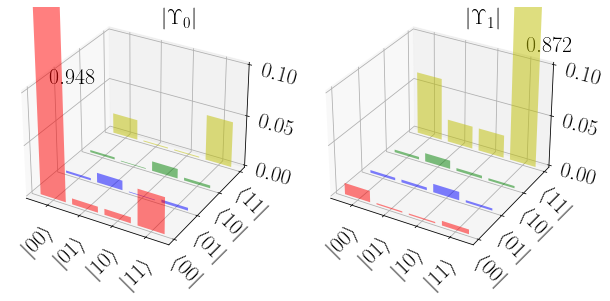

In [55]:
axes = Plot_Chois(chois1 )

Labels = [ r'$|\Upsilon_0|$', r'$|\Upsilon_1|$'  ]
j = 0
for ax in axes:
    ax.set_xticks( [0,1,2,3] )
    ax.set_xticklabels( [r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$',r'$|11\rangle$'] )
    ax.set_yticks( [0,1,2,3] )
    ax.set_yticklabels( [r'$\langle 00|$', r'$\langle 01|$', r'$\langle 10|$', r'$\langle 11|$'] )
    ax.text( 0.5, 4, 0.1, Labels[j], size = 22 )

    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=-45)
    ax.tick_params(axis='z', rotation=-15, pad=10)
    j += 1
plt.savefig('choi_mar_1.svg', bbox_inches='tight' )

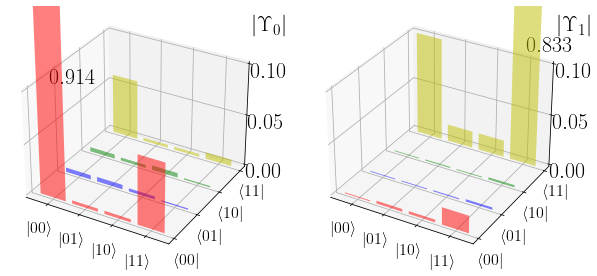

In [56]:
axes = Plot_Chois( chois2 )

Labels = [ r'$|\Upsilon_0|$', r'$|\Upsilon_1|$'  ]
j = 0
for ax in axes:
    ax.set_xticks( [0,1,2,3] )
    ax.set_xticklabels( [r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$',r'$|11\rangle$'], size=16 )
    ax.set_yticks( [0,1,2,3] )
    ax.set_yticklabels( [r'$\langle 00|$', r'$\langle 01|$', r'$\langle 10|$', r'$\langle 11|$'], size=16 )
    ax.text( 3.3, 4, 0.1*1.15, Labels[j], size = 22 )
    j += 1
plt.savefig('choi_mar_2.svg', bbox_inches='tight' )

In [ ]:
from qiskit.compiler import schedule

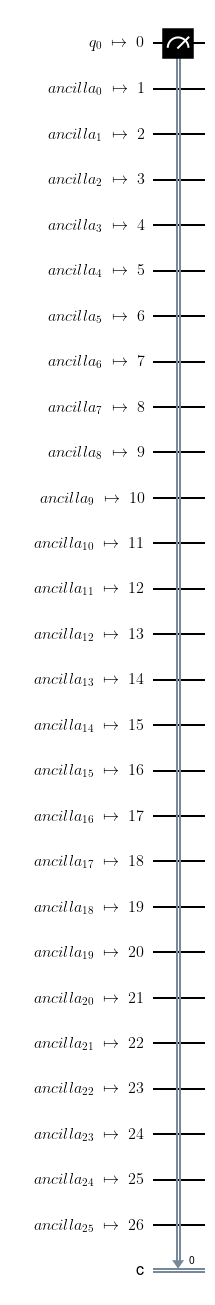

In [ ]:
circ = QuantumCircuit(1,1)
circ.measure(0,0)
circ = transpile(circ,backend)
circ.draw(output='mpl')


In [ ]:
pulses = schedule(circ, backend=backend )

In [ ]:
pulses.draw()

RuntimeError: latex was not able to process the following string:
b'M_m0'

Here is the full report generated by latex:
latex: security risk: running with elevated privileges
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 21.12.10) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(C:/Users/lucia/.matplotlib/tex.cache/4c36b7a866865f0ce496f5024c40ba61.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\lucia\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\lucia\AppData\Roaming\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\lucia\AppData\Roaming\MiKTeX\tex/latex/psnfss\helvet.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\lucia\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\lucia\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file 4c36b7a866865f0ce496f5024c40ba61.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\lucia\AppData\Roaming\MiKTeX\tex/latex/psnfss\ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily M_
                  m0}
No pages of output.
Transcript written on 4c36b7a866865f0ce496f5024c40ba61.log.




<Figure size 936x118.8 with 1 Axes>

In [ ]:
# medida 22000dt
# cavity reset? 4000dt
# total 26000dt 
# gate time 250dt

In [ ]:
backend.configuration().dt # units of seconds

2.2222222222222221e-10

In [ ]:
#measurement
#0.2*26000 = 5200ns

#local gate
#0.2*250 = 50 ns

#CNOT
#300ns y 700ns